In [1]:
ENV='MiniHack-KeyRoom-S15-v0'
# ENV='MiniHack-CorridorBattle-v0'
H = 10
W = 10
NUM_EPISODES = 1
MAX_STEPS = 30
PATH = 'kbkey.pl'

In [2]:
from utilsk import decide_next_cell_to_explore, initialize,perform_action,coordinates_to_actions,astar,obschar_to_mask, actions, positions,  process_state, show_match
from pyswip import Prolog
import matplotlib.pyplot as plt
import numpy as np
import time


In [3]:
KB = Prolog()
KB.consult(PATH)

In [4]:
import gym
import minihack
import matplotlib.pyplot as plt
initialize()
env = gym.make(ENV,
               observation_keys=('screen_descriptions','chars','glyphs','inv_strs','blstats','message','pixel','pixel_crop'))
obs=env.reset() # each reset generates a new environment instance
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
                                       ---------                                
                                       |.......|                                
                                       |....@..|                                
                                       |.......|                                
                                       |.......|                                
                                       |.......|                                
                                       -.......|                                
                                       ........|                                
                           

west


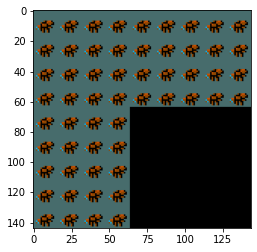

In [20]:
obs, reward, done, info=perform_action('west', env, KB)
plt.imshow(obs['pixel_crop'])

In [6]:
env.render()


It's a wall.                                                                    
                                                                                
                                                                                
                                                                                
                               --- -------------                                
                               |.| ....|.......|                                
                               |.|>....|....<..|                                
                               |.|.....|.......|                                
                               |.@.....|.......|                                
                               |.|.....|.......|                                
                               |.-------.......|                                
                               |...............|                                
                           

In [25]:
process_state(obs, KB)


In [14]:
action = list(KB.query('action(X)'))[0]["X"]

In [15]:
action

'go(stairs)'

In [ ]:
list(KB.query('action(X)'))

Episode 0 - 31 steps
End status: RUNNING
Final reward: -0.01
After 1 episodes, mean return is 0.0
The rewards of the episodes are: []


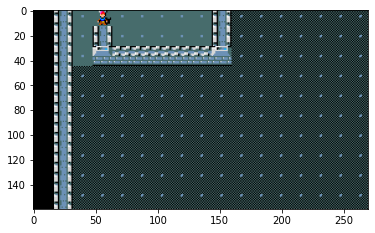

In [5]:
rewards = []
performed_acts=[]
for episode in range(NUM_EPISODES):
    initialize()

    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    # obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False
    info=None

    # Main loop
    plan=[]
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb 
        process_state(obs, KB)

        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
       
        action = list(KB.query('action(X)'))[0]["X"]
      
        # print(f'>> Current action from Prolog: {action}')
        
        if action:
            navs=[]
            if 'go(stairs)' in action:
                agent_p=positions['agent']
                stairs_p=positions['stairs']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, stairs_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

            elif 'enter(door)' in action:
                agent_p=positions['agent']
                door_p=positions['door']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                
            elif 'opendoor' in action:
                obs, reward, done, info = perform_action("opendoor", env, KB)
                performed_acts+=["opendoor"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            elif "pick" in action:
                obs, reward, done, info = perform_action("pick", env, KB)
                performed_acts+=["pick"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            if "go(door)" in action:
                agent_p=positions['agent']
                door_p=positions['door_front']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

                
            elif "go(key)" in action:
                agent_p=positions['agent']
                key_p=positions['key']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, key_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                
            elif 'explore' in action:
                b_cell=decide_next_cell_to_explore(obs)
                agent_p=positions['agent']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, b_cell)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                
            for nav in navs:
                
                if list(KB.query('action(X)'))[0]["X"] != action:
                    break
                    
                obs, reward, done, info = perform_action(nav, env, KB)
                performed_acts+=[nav]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()

            
                
                

                
                

        else:
            print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
            break


    # Display game with interface
    show_match(ep_states)
    # Print information about the ended episode
    print(f'Episode {episode} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')
    time.sleep(0.75)

    # rewards.append(reward)

    # # reset the environment and retract axioms that may cause errors
    # obs = env.reset()
    # KB.retractall('stepping_on(agent,_,_)')


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print("The rewards of the episodes are:", rewards)

In [22]:
performed_acts

['west']

In [12]:
map=obs['chars']

In [13]:
# Create a mask for cells with ASCII values "(" or "." or "<"
mask = np.logical_or(map == 40, map == 46, map == 60)

# Convert to a new 2D array with 0 or 1
new_array = np.where(mask, 0, 1)


In [12]:
obs['chars'][0][0]

32

In [29]:
for i in range(21):
        for j in range(79):
            if not (obs['chars'][i][j] == 0).all():
                obj = obs['chars'][i][j]
                if obj!=32:
                    print(obj,chr(obj),bytes(obs['screen_descriptions'][i][j]).decode('utf-8').rstrip('\x00'), obs['glyphs'][i][j] )

45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2363
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
124 | wall 2360
45 - wall 2362
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2361
45 - wall 2363
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
46 . dark part of a room 2379
124 | wall 2360
124 | wall 2360
46 . floor of a room 2378
46 . floor of a room 2378
46 . floor of a room 2378
46 . floor of a roo

In [18]:
start=positions['agent']
end=positions['key']

In [19]:
start, end

((11, 41), (11, 40))

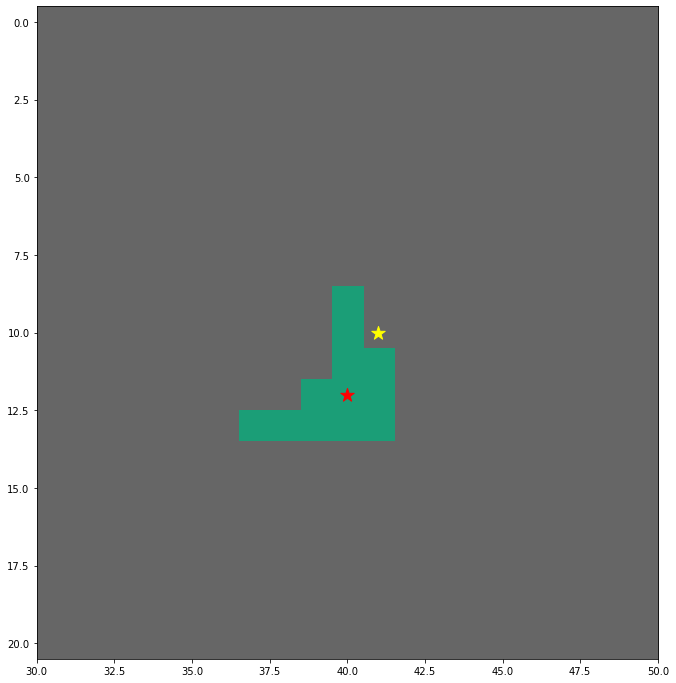

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

ax.imshow(new_array, cmap=plt.cm.Dark2)

ax.scatter(start[1],start[0], marker = "*", color = "yellow", s = 200)

ax.scatter(end[1],end[0], marker = "*", color = "red", s = 200)

plt.xlim(30,50)
plt.show()

In [17]:
route = astar(new_array, start, end)
route.reverse()


In [18]:
route

[(11, 40), (12, 40)]

In [19]:
positions["agent"]

(10, 41)

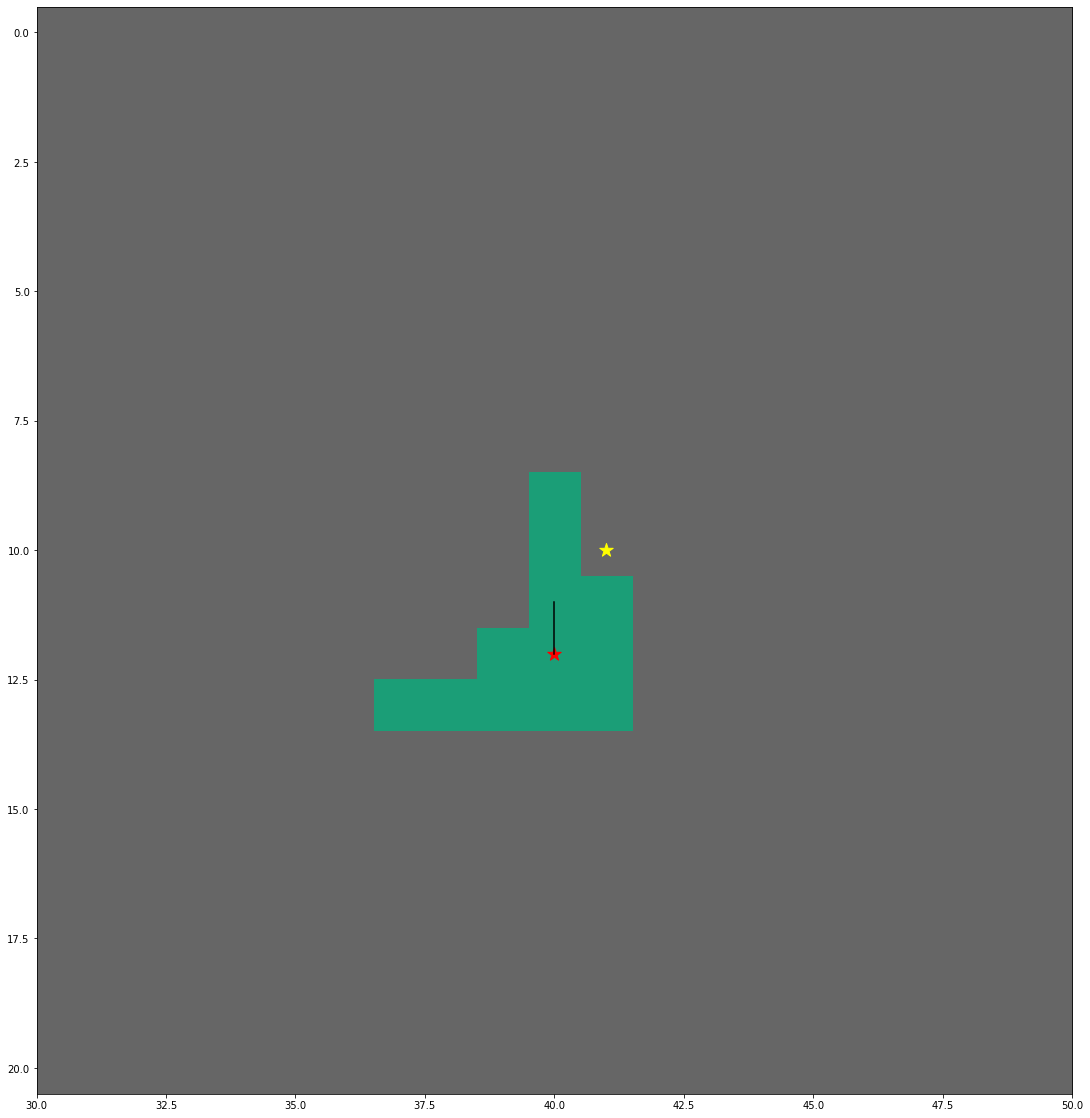

In [20]:
x_coords = []

y_coords = []

for i in (range(0,len(route))):

    x = route[i][0]

    y = route[i][1]

    x_coords.append(x)

    y_coords.append(y)

# plot map and path

fig, ax = plt.subplots(figsize=(20,20))

ax.imshow(new_array, cmap=plt.cm.Dark2)

ax.scatter(start[1],start[0], marker = "*", color = "yellow", s = 200)
plt.xlim(30,50)

ax.scatter(end[1],end[0], marker = "*", color = "red", s = 200)

ax.plot(y_coords,x_coords, color = "black")

plt.show()

In [21]:



actions = coordinates_to_actions([positions["agent"]]+route)
print(actions)


['southwest', 'south']


In [18]:
import random

In [8]:
positions["door"]

(12, 39)

In [12]:
obs['glyphs'][positions["door"]]

2372